In [2]:
from my_rem import *
from my_ddd import *
from my_lib import *

from typing import List, Callable
import numpy as np
from matplotlib import pyplot as plt

import qiskit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

from mitiq.interface.mitiq_qiskit import to_qiskit
from mitiq import ddd, QPROGRAM
from mitiq.ddd import insert_ddd_sequences

from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error, phase_damping_error, phase_amplitude_damping_error

In [3]:
import cirq

# Importing the cirq module

# Defining a function for the repeated ixix rule
def rep_ixix_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(
        window_length, [cirq.I, cirq.X, cirq.I, cirq.X]
    )

# Defining a function for the repeated xx rule
def rep_xx_rule(window_length: int) -> Callable[[int], QPROGRAM]:
    return ddd.rules.repeated_rule(window_length, [cirq.X, cirq.X])

In [4]:
# Error Parameters
p_readout_flip = 0.00
p_circuit_depolarizing = 0.1
gamma_dephasing = 0.1
gamma_amplitude_damping = 0.1
thermal_population = 0.1

# Possible Errors 
error_meas = pauli_error([('X', p_readout_flip), ('I', 1 - p_readout_flip)])
error_depolarizing_1q = depolarizing_error(p_circuit_depolarizing, 1)
error_depolarizing_2q = depolarizing_error(p_circuit_depolarizing, 2)
error_dephasing_1q = phase_damping_error(gamma_dephasing)
error_phase_amplitude_damping = phase_amplitude_damping_error(gamma_dephasing, gamma_amplitude_damping, thermal_population)

In [5]:
num_qubits = 2  # Number of qubits in the circuit

# Initialize a random circuit
num_operations = 5  # Number of initial random operations
idle_depth = 20  # Number of idle operations to add
circuit = create_random_circuit_with_idle_windows(num_qubits, num_operations, idle_depth)

#create the mitigator, that will be applied a posteriori
mitigator_shots = 1000
readout_noise = get_readout_noise(error_meas)
mitigator_instance = generate_mitigator(num_qubits, mitigator_shots, readout_noise, False)

In [6]:
def get_circuit(depth: int):
    """Returns a circuit composed of a GHZ sequence, idle windows,
    and finally an inverse GHZ sequence.

    Args:
        depth: The depth of the idle window in the circuit.
    """
    circuit = qiskit.QuantumCircuit(num_qubits, num_qubits)
    circuit.h(0)
    circuit.cx(0, 1)
    for _ in range(depth):
        circuit.id(0)
        circuit.id(1)
    circuit.cx(0, 1)
    circuit.h(0)
    circuit.measure(0, 0)
    return circuit

In [13]:
circuit = get_circuit(50)
print(circuit)

     ┌───┐     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
q_0: ┤ H ├──■──┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├»
     └───┘┌─┴─┐├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
q_1: ─────┤ X ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├»
          └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 2/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_0: ┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├»
«     ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
«q_1: ┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«c: 2/═════════════════════════════════════════════════════════════════

In [17]:
# Define other parameters
reps = 100000
noise = get_combined_noise(error_meas, error_phase_amplitude_damping)
ddd_flag = True
shots = 10000
ddd_sequence = rep_xx_rule  # Use appropriate DDD sequence from mitiq

# Apply DDD (if required) and run the circuit
counts = apply_ddd_and_run(
    circuit,
    noise=noise,
    reps=reps,
    ddd=ddd_flag,
    ddd_rule=ddd_sequence,
    output=True
)

print(counts)

# Apply the mitigator (if required) to the results
probabilities = apply_mitigator(
    counts,
    n_qubits=num_qubits,
    reps=reps,
    mitigator_instance=mitigator_instance,
    output=False
)

print(probabilities)

Original circuit
     ┌───┐     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
q_0: ┤ H ├──■──┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├»
     └───┘┌─┴─┐├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
q_1: ─────┤ X ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├»
          └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 2/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐»
«q_0: ┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├»
«     ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤»
«q_1: ┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├┤ I ├»
«     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
«c: 2/════════════════════════════════════════════════

In [15]:
# Assuming you have already defined the circuit, noise model, and other necessary parameters
result_no_noise_no_mit, result_noise_no_mit, result_noise_rem_no_ddd, result_noise_no_rem_ddd, result_noise_rem_ddd = run_cases(circuit, noise=noise, reps=1000, n_qubits=2, ddd_rule=ddd_sequence)
results_list = [result_no_noise_no_mit, result_noise_no_mit, result_noise_rem_no_ddd, result_noise_no_rem_ddd, result_noise_rem_ddd]
print(results_list)

Running with no noise, no mitigation ... 

Final Probabilities={'00': 1.0, '01': 0.0, '10': 0.0, '11': 0.0}

 

Running with noise, no mitigation ... 

Running with noise, mitigation True, DDD False ... 

Running with noise, mitigation False, DDD True ... 

Running with noise, mitigation True, DDD True ... 

[{'00': 1.0, '01': 0.0, '10': 0.0, '11': 0.0}, {'00': 0.95, '01': 0.05, '10': 0.0, '11': 0.0}, {'00': 0.942, '01': 0.058, '10': 0.0, '11': 0.0}, {'00': 0.537, '01': 0.463, '10': 0.0, '11': 0.0}, {'00': 0.536, '01': 0.464, '10': 0.0, '11': 0.0}]


Text(0, 0.5, 'Probabilities')

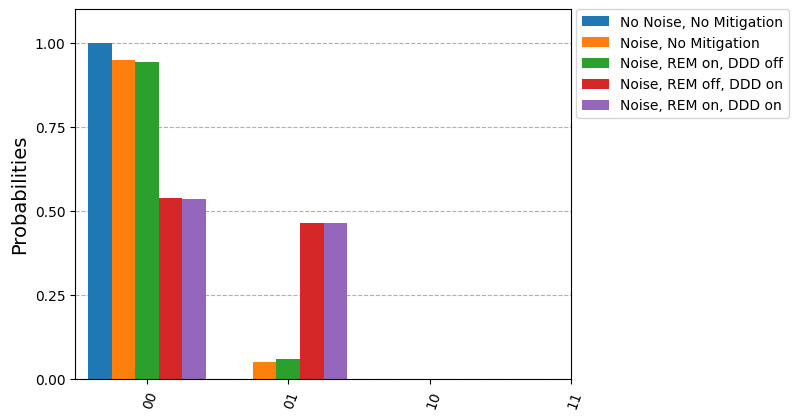

In [16]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


labels = [
    'No Noise, No Mitigation', 'Noise, No Mitigation',
    'Noise, REM on, DDD off', 'Noise, REM off, DDD on', 'Noise, REM on, DDD on'
]


# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Now, use the ax parameter to specify where to plot the histogram
plot_histogram(results_list, legend=labels, bar_labels=False, ax=ax)
ax.set_ylabel('Probabilities')